In [1]:
library('BoolNet')
library('dplyr')
library('alluvial')
library("stringr")
library('pheatmap')
for (f in list.files("BNP")) { source( paste('BNP/', f, sep='') ) }

# Load data
net <- loadNetwork(file = "../CSV/reduced_boolean_network_basin.csv")
labels <- read.csv("../CSV/label_rules_1.csv")


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message in loadNetwork(file = "../CSV/reduced_boolean_network_basin.csv"):
"There is no transition function for gene "IFNG_e"! Assuming an input!"Warning message in loadNetwork(file = "../CSV/reduced_boolean_network_basin.csv"):
"There is no transition function for gene "GMCSF_e"! Assuming an input!"Warning message in loadNetwork(file = "../CSV/reduced_boolean_network_basin.csv"):
"There is no transition function for gene "IL1B_e"! Assuming an input!"Warning message in loadNetwork(file = "../CSV/reduced_boolean_network_basin.csv"):
"There is no transition function for gene "IC_e"! Assuming an input!"Warning message in loadNetwork(file = "../CSV/reduced_boolean_network_basin.csv"):
"There is no transition function for gene "LPS_e"! Assuming an input!"Warning message in loadNetwork(fil

## Full Regulatory Network

![title](../MODEL/full_boolean_network_picture.jpg)

## Reduced Regulatory Network

![title](../MODEL/reduced_boolean_network_picture.jpg)

In [2]:
file.attr <- "../CSV/reduced_network_attractors.csv"
file.attr.pdf <- "images/thsocs_attr.pdf"

if (! file.exists(file.attr)) {
    cell_types <- labelAttractors(attr, labels, sep="/")
    # Getting df of attractors
    attr.table <- attractorToDataframe(attr, Boolean = T)
    cell.type <- unlist(sapply(cell_types, function(type){
        if(str_detect(type, "/")){
            multiple <- length(str_extract_all(type,"/")[[1]]) + 1
            return(rep(type, multiple))
        }
        return(type)
    }))
    attr.table <- cbind(attr.table, cell.type = cell.type)
    # Sorting attractor table by estimulus
    est.ind <- (which(str_detect(colnames(attr.table), "_e") == T))
    attr.table <- attr.table[,c(1,2,est.ind ,(3:ncol(attr.table))[-(est.ind-2)])]
    attr.table <- attr.table[order(attr.table$cell.type),]
    write.csv(attr.table,file = file.attr)
} else {
    attr.table <- read.csv(file = file.attr)
}

[1] 1
[1] 2


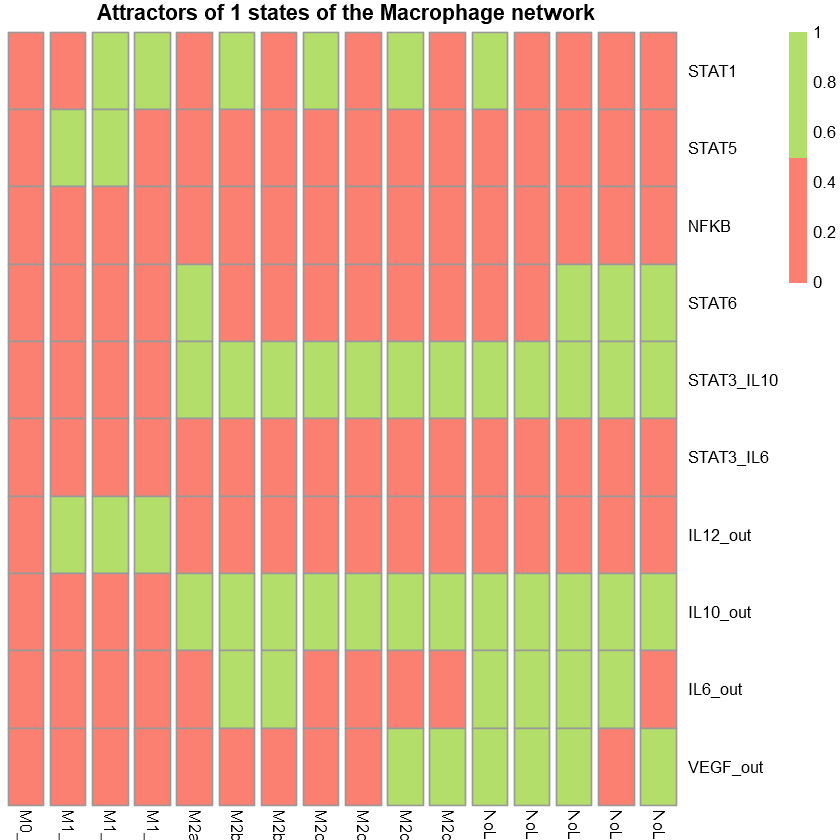

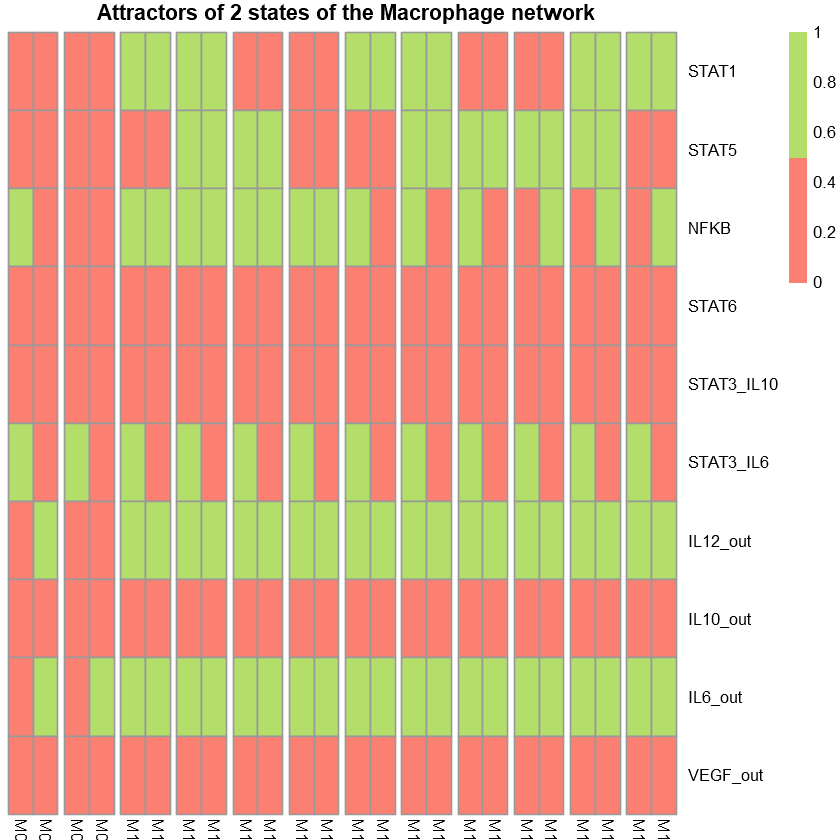

[1] 3


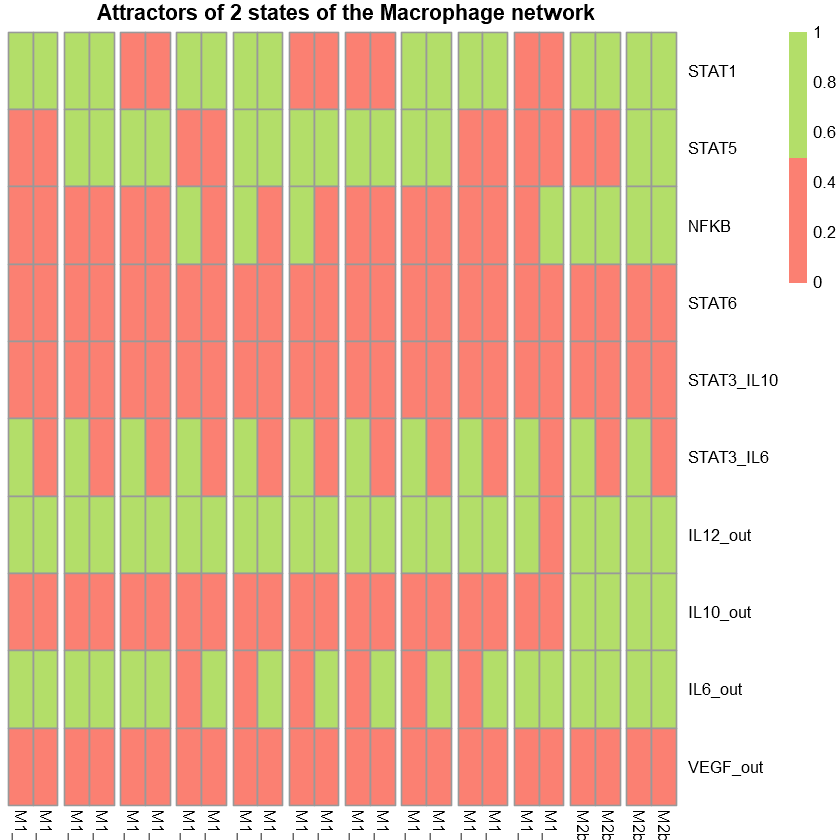

[1] 6


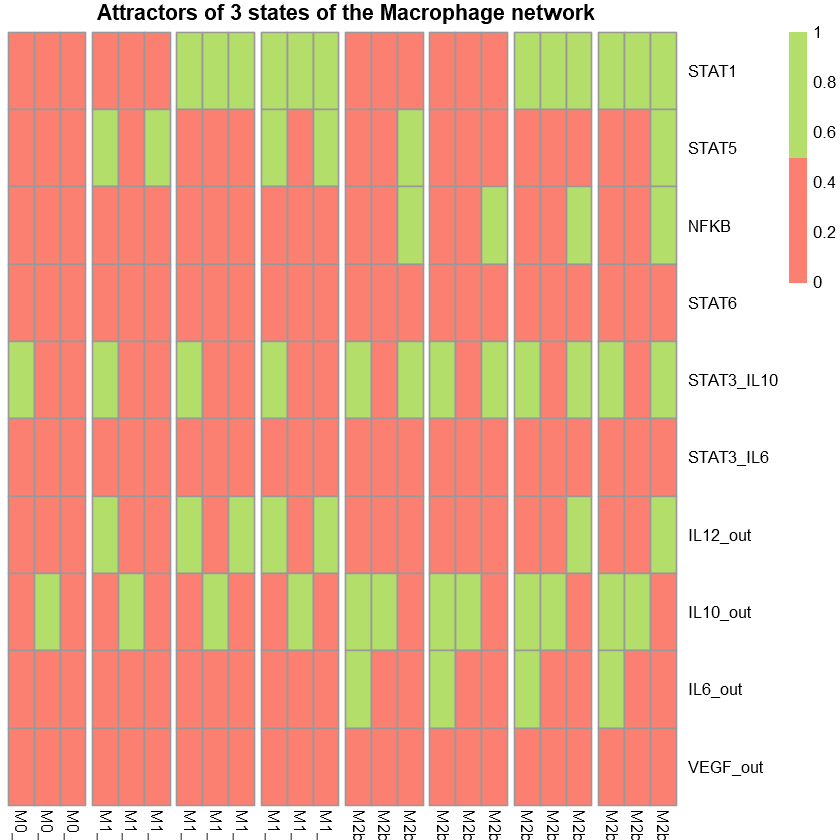

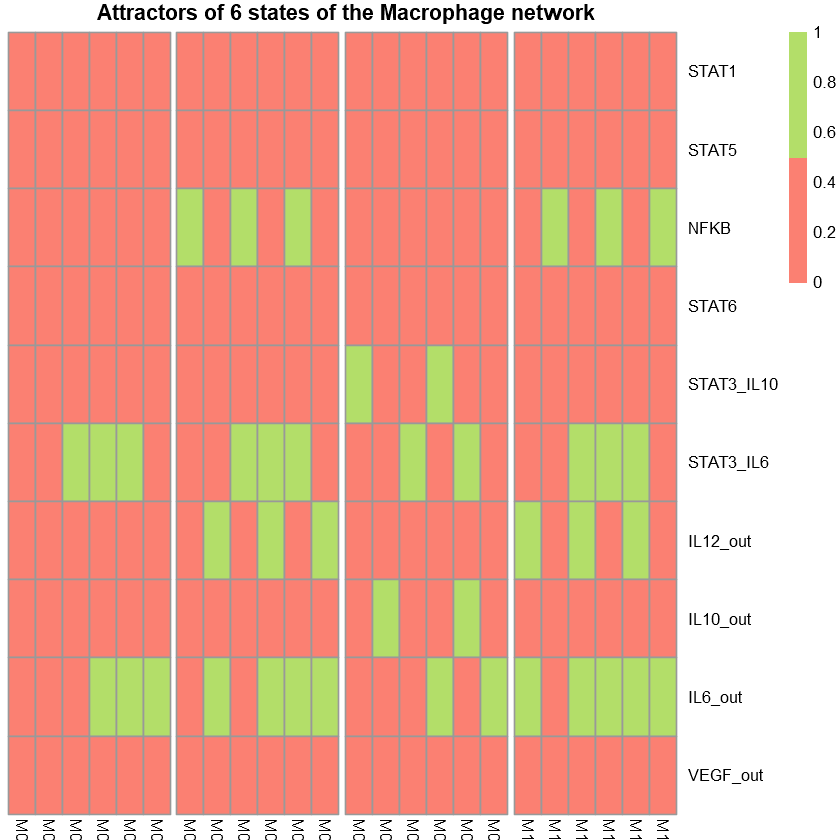

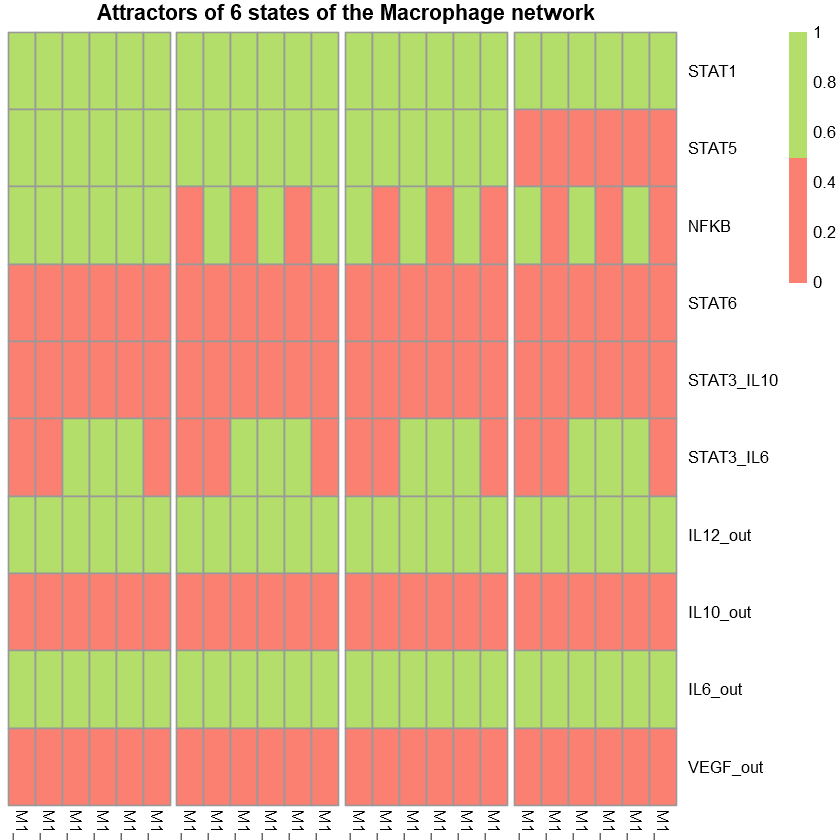

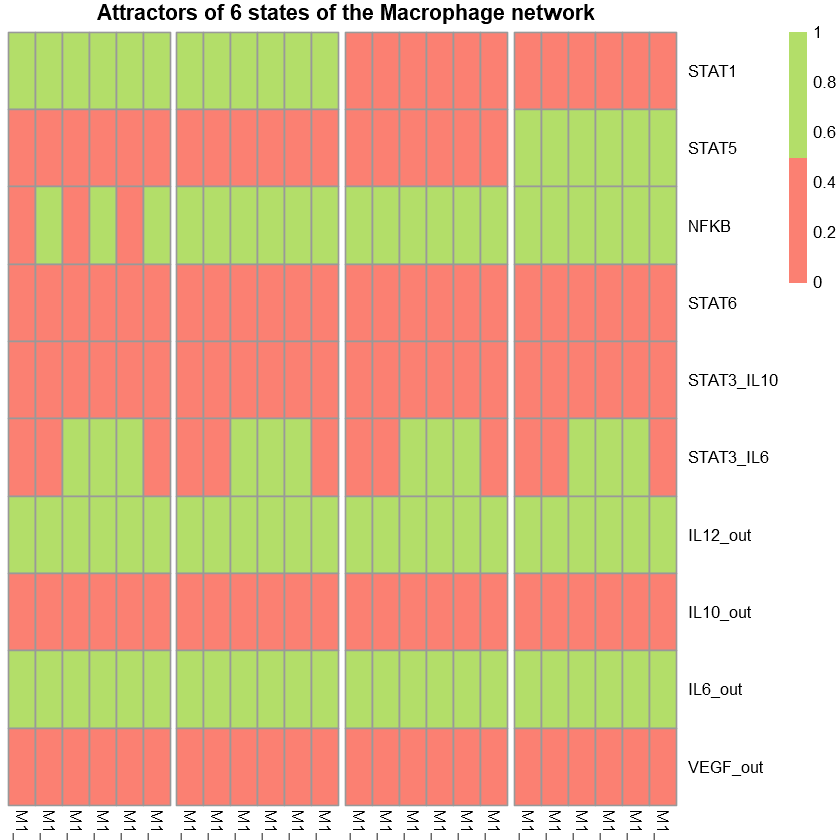

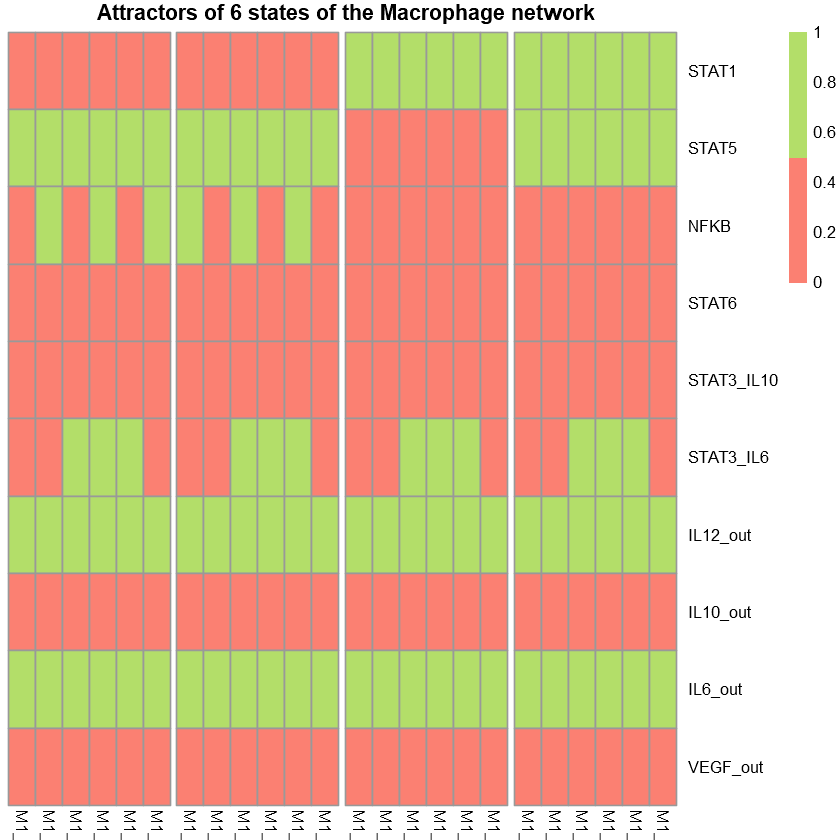

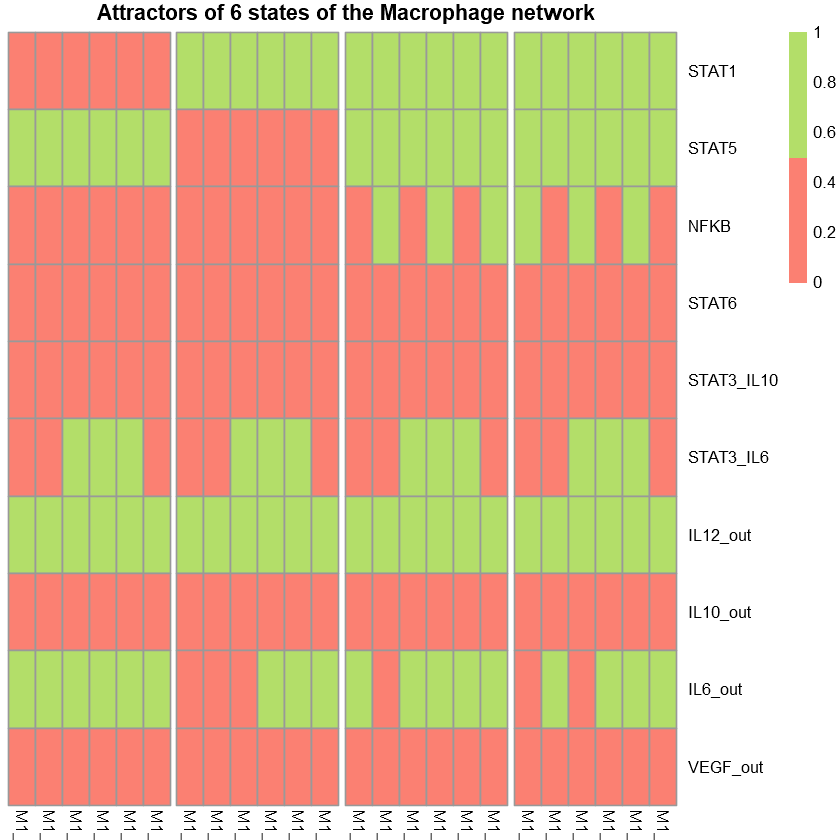

In [3]:
# Fucntions to get plots of attractors cycles

get_cycles <- function(cycles, attr.table){
   if(all(!(str_count(unique(attr.table$attractor), "/") %in% (cycles-1)))) return(NA)
   cycles.states <- unique(attr.table$attractor)[str_count(unique(attr.table$attractor), "/") == (cycles-1)]
   attr.table.cycles <- attr.table[attr.table$attractor %in% cycles.states,]
   row.n <- seq(1,nrow(attr.table.cycles), cycles)
   attr.table.cycles.proof <- attr.table.cycles[row.n,]
   for (n in 1:(cycles-1)) {
      attr.table.cycles.proof <- cbind(attr.table.cycles.proof, attr.table.cycles[row.n+n,])
   }
   attr.table.cycles.proof <- cbind(unique(attr.table.cycles.proof),
                                 state = 1:nrow(unique(attr.table.cycles.proof)))
   rm(attr.table.cycles)
   col.factor <- floor(ncol(attr.table.cycles.proof)/cycles)
   attr.table.cycles <- cbind(attr.table.cycles.proof[,c(1:col.factor)],
                           state = seq(1,nrow(attr.table.cycles.proof)*cycles, cycles))
   for(n in 1:(cycles-1)){
      seq.n <- seq(n+1, nrow(attr.table.cycles.proof)*cycles, cycles)
      attr.table.cycles <- rbind(attr.table.cycles,
                              cbind(attr.table.cycles.proof[,((n*col.factor)+1):((n+1)*col.factor)],
                                    state = seq.n))
   }
   rm(attr.table.cycles.proof)
   attr.table.cycles <- attr.table.cycles[order(attr.table.cycles$state),-ncol(attr.table.cycles)]
   attr.table.cycles
}
plot.heatmap <- function(attr.table, title, gaps){
   pheatmap(t(as.matrix( subset(attr.table, select=-attractor ))),
            labels_col = attr.table[,"attractor"],
            main= title,
            color=c('#fb8072','#b3de69'),
            cluster_cols = F, cluster_rows = F,
            gaps_col = gaps, scale = "none"
   )
}
# select key nodes for plotting
attr.table <- subset(attr.table, select = c("cell.type", "STAT1", "STAT5", "NFKB", "STAT6",
                                               "STAT3_IL10", "STAT3_IL6", "IL12_out", "IL10_out", "IL6_out", "VEGF_out") )
colnames(attr.table)[1] <- "attractor"
attr.cycles.list <- list()
attr.cycles.list$fp <- attr.table[attr.table$attractor %in% c("M0__","M1__", "M2a__", "M2b__", "M2c__", "M2d__", "NoLabel"),]
attr.cycles.list$fp <- unique(attr.cycles.list$fp)
max.cycle <- max(str_count(unique(attr.table$attractor),"/"))+1
for (n in 2:max.cycle) {
   attr.cycles.list[[n]] <- get_cycles(cycles = n, attr.table = attr.table)
}
#pdf(file = "PLOT/attractors.heatmaps.pdf")
for(n in 1:max.cycle){
   if(class(attr.cycles.list[[n]]) == "logical") next
   print(n)
   n.attr <- nrow(attr.cycles.list[[n]])/n
   title <- paste0("Attractors of ", n, " states of the Macrophage network")
   for(block in 1:ceiling(n.attr/24)){
      up.limit <- block*24
      low.limit <- ((block-1)*24)+1
      gap <- 24
      if(all(is.na(attr.cycles.list[[n]][up.limit,]))){
         up.limit <- (low.limit-1) + nrow(na.omit(attr.cycles.list[[n]][low.limit:up.limit,]))
         gap <- nrow(na.omit(attr.cycles.list[[n]][low.limit:up.limit,]))
      }
      plot.heatmap(attr.table = attr.cycles.list[[n]][low.limit:up.limit,],
                   title = title,
                   gaps = seq(n, gap, n))
   }
}
#dev.off()

## Enviroments

In [4]:
file.env <- "../CSV/enviroments.csv"
if (! file.exists(file.attr)) {
    estimulus <- net$genes[str_detect(net$genes, "_e")]
    set.env <- function(genes, estimulus){
        ind <- match(genes, estimulus)
        env <- rep(0, length(estimulus))
        env[ind] <- 1
        names(env) <- estimulus
        env
    }
    pro_M1 <- set.env(c("IFNG_e", "LPS_e", "GMCSF_e"), estimulus)
    pro_M2a <- set.env(c("IL4_e"), estimulus)
    pro_M2b <- set.env(c("LPS_e","IC_e", "IL1B_e"), estimulus)
    pro_M2c <- set.env(c("IL10_e"), estimulus)
    pro_M2d <- set.env(c("LPS_e", "IL6_e", "NECA_e"), estimulus)
    envMacrophages <- list(label = c("pro_M1", "pro_M2a", "pro_M2b", "pro_M2c", "pro_M2d"),
                       nodes = list(estimulus,estimulus,estimulus,estimulus,estimulus),
                       values = list(pro_M1, pro_M2a, pro_M2b, pro_M2c, pro_M2d))
    env.attr <- perturbNetworkFixedNodes(net, label.rules = labels,
                                     genes = envMacrophages$nodes,
                                     values = envMacrophages$values,
                                     names = envMacrophages$label,
                                     method = "sat.restricted",
                                     maxAttractorLength = 2)
    write.csv(x = env.attr, file = "CSV/enviroments.csv")
} else {
    env.attr <- read.csv(file.env)
}

# Plot enviroments
env.attr

X,pro_M1,pro_M2a,pro_M2b,pro_M2c,pro_M2d
M1__/M1__,1,0,0,0,0
M2a__,0,1,0,0,0
M2b__/M2b__,0,0,1,0,0
M2c__,1,0,0,1,0
M2d__,0,0,0,0,1
NoLabel/NoLabel,0,0,0,0,1


## Macrophage Plasticity

In [5]:
f.cfm.table <- function(net, lab, file.name) {
    if (! file.exists(file.name)) {
        cfm <- cellFateMap(net, label.rules=lab, 
                           method="sat.restricted", maxAttractorLength=2) 
        cfm <- apply(cfm,2,as.character)
        cfm <- cfm[  order( cfm[,1], cfm[,2], cfm[,3], cfm[,4] ),]
        write.csv(cfm,file.name, row.names=F)
    } else {
        cfm <- read.csv(file = file.name)
    }
    cfm
}
cfm <- f.cfm.table(net, labels, "../CSV/cellfate.csv")

In [10]:
head(cfm)

X,initial,final,genes,values
1,M0__,M0__,STAT1,1
2,M0__,M0__,STAT5,1
3,M0__,M1__/M1__/M1__/M1__/M1__/M1__,IL1R,1
4,M0__,M0__,IL12_out,1
5,M0__,M2c__/NoLabel/M0__,FCGR,1
6,M0__,M1__/M1__/M1__/M1__/M1__/M1__,NFKB,1


[1] "Transitions between cell types"
# A tibble: 188 x 3
# Groups:   initial [7]
   initial final                                      freq
   <fct>   <fct>                                     <int>
 1 M0__    M0__                                        136
 2 M0__    M0__/M0__/M0__/NoLabel/NoLabel/NoLabel      256
 3 M0__    M0__/M1__                                    48
 4 M0__    M0__/M1__/M0__/M1__/NoLabel/M1__            132
 5 M0__    M0__/NoLabel                                 68
 6 M0__    M0__/NoLabel/M0__                           284
 7 M0__    M0__/NoLabel/M0__/NoLabel/NoLabel/NoLabel   188
 8 M0__    M1__                                         16
 9 M0__    M1__/M0__/M1__/NoLabel/M1__/NoLabel          72
10 M0__    M1__/M1__                                    32
# ... with 178 more rows


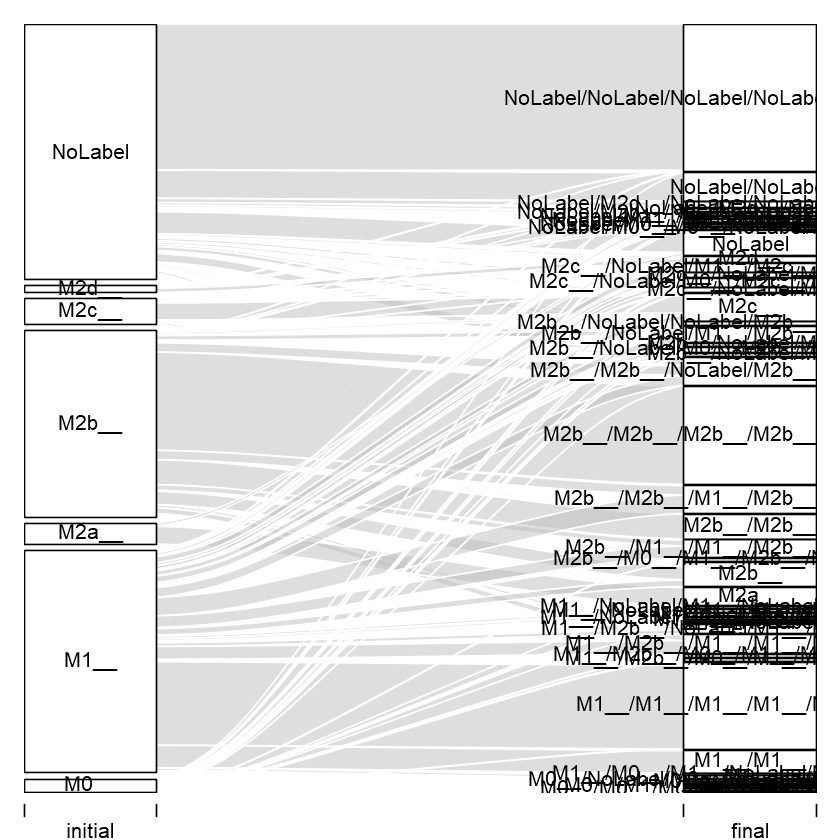

In [6]:
plot.cfm.alluvial <- function(cfm, file.name, title='', ignore='Naive') {
    if (! file.exists(file.name)) { 
        pdf(file.name) 
        save.pdf=T
    } else { 
        save.pdf <- F
    }
    cfm <- cfm[cfm$initial!=ignore,]
    cfm %>% group_by(initial, final) %>%
            summarize(freq = n()) -> cfm2d
    print(title)
    print(cfm2d)
    alluvial(cfm2d[,1:2], freq=cfm2d$freq)
    if (save.pdf) { dev.off() }
    }

plot.cfm.alluvial(cfm, '../PLOT/alluvial.pdf',
                  title='Transitions between cell types')

## Mutants

In [15]:
f.mut.plot <- function(mutants, image.name, save.pdf=FALSE, normalize=T) {
    if (save.pdf) { pdf(image.name) }
    if (normalize) {
        mutants <- mutants/mutants
        color <- c('#bebada')
    } else {
        colfunc <- colorRampPalette(c('#bfd3e6', '#810f7c'))
        color <- colfunc(10)
    }
    
    heatmap(t(as.matrix( mutants )),
            main="Macrophage subsets mutants", 
            xlab="Macrophage subset", ylab="Mutant",
            col=color, cexCol=0.75, cexRow=0.75,
            Colv = NA, Rowv = NA, scale="none",
           )
    if (save.pdf) {dev.off() }
}

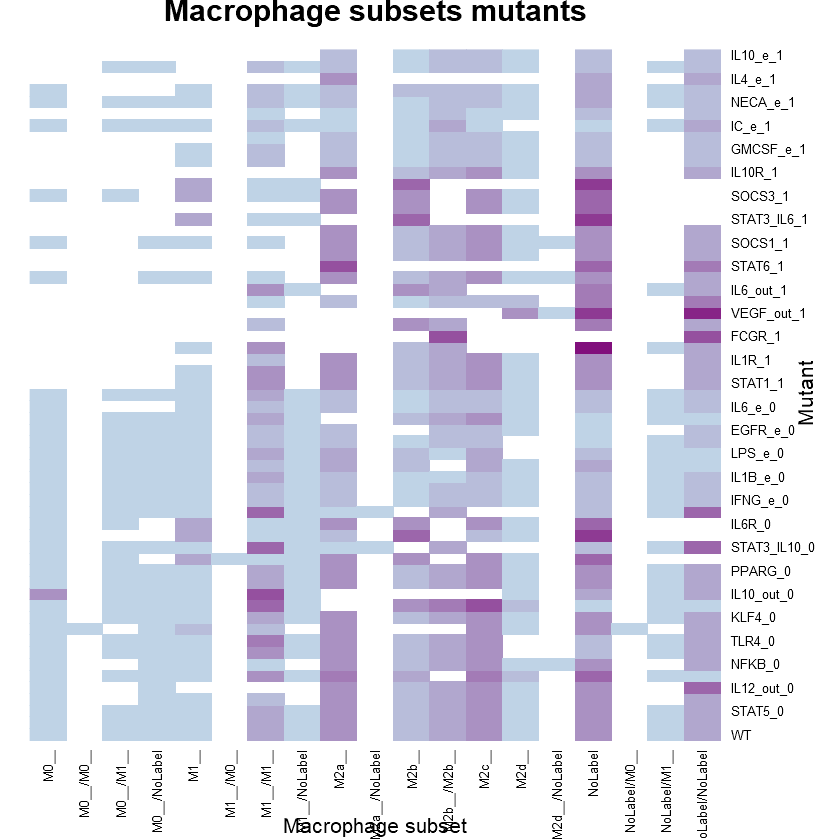

In [17]:
mutants <- read.csv(file = "../CSV/mutants.csv", row.names = 1)
mutants[mutants==0] <- NA
f.mut.plot(mutants, image.name = "../PLOT/mut_wt.pdf", save.pdf=FALSE, normalize=F)